# Image Search on Brain MRI Scans

This example demonstrates how to store [brain scan images](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) as vector embeddings in KDB.AI, then how to search this dataset to instantly retrieve similar images.

Brain tumors are intricate due to variations in size and location, therefore understanding their nature is challenging. Professional neurosurgeons are essential for accurate MRI analysis, but in developing nations, the scarcity of skilled doctors and tumor knowledge results in time-consuming report generation from MRI scans. 

A potential solution lies in automated systems like vector database search, which could help alleviate this issue. Using semantic search, KDB.AI enables users to effectively retrieve the most similar scan images quickly even when the query and database content aren't an exact match, leveraging semantic context. 

### Aim 
In this tutorial, we'll walk through the process of storing images in a vector database, using a pre-trained neural network to generate data structures known as vector embeddings. We will use KDB.AI's vector database offering to find images with similar vector embeddings to an input query image. We will cover the following topics:

1. Load Image Data
1. Create Image Vector Embeddings
1. Store Embeddings in KDB.AI
1. Query the KDB.AI Table
1. Search For Similar Images To A Target Image
1. Delete the KDB.AI Table

---

## 0. Setup

### Install dependencies 

In order to successfully run this sample, the [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` file must be completed.
This will ensure that you have installed all of the relevant packages and versions needed for this sample.
If you have not completed these setup steps, please navigate to the repositories `README.md` file and follow the steps detailed there.

### Set Environment Variables

In [1]:
import os

In [2]:
### ignore tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
# force tensorflow to use CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

### Import Packages

In [4]:
# download data
from zipfile import ZipFile

In [5]:
# embeddings
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from huggingface_hub import from_pretrained_keras
from PIL import Image
import numpy as np
import pandas as pd

In [6]:
# timing
from tqdm.auto import tqdm

In [7]:
# vector DB
import kdbai_client as kdbai
from getpass import getpass
import time

In [8]:
# plotting
import umap.umap_ as umap
from matplotlib import pyplot as plt

### Define Helper Functions

In [9]:
def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()

In [10]:
def plot_image(axis, source: str, label=None) -> None:
    axis.imshow(plt.imread(source), cmap = 'gray')
    axis.axis("off")
    title = (f"{label}: " if label else "") + source.split("/")[-1]
    axis.set_title(title)

## 1. Load Image Data

### Dataset Overview

The dataset that will be used in this sample is the [Brain Tumor Classification images taken from Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri).
The dataset consists of MRI brain scan images organized into four classes based on the presence of a tumor in the image: glioma, melignioma, pituitary, and no tumor.

The original Kaggle dataset contains two folders a `Training` folder and a `Testing` folder, both of which contain images organized by these tumor class.
As a pre-processing step, we have resized the original images to be of dimensions (224, 224, 3) with the height & width being 224 and there being 3 dimensions for the Red, Green, and Blue pixel intensity.
We have also renamed each image corresponding to its class and given each one a unique ID within its directory.

Post processing, the `Training` folder in this original dataset was used to train the ResNet model which we use to create the embeddings in this notebook.
The post processed `Testing` folder has been renamed to `data` and will be what we use in this notebook.
This data has not been seen by our ResNet model and will help to avoid any overfitting when it comes to creating the vector embeddings.

### Define List Of Paths To The Extracted Image Files

Next, let's extract image file paths from different subfolders within the 'Testing' directory. These are needed to pass to our function in the next section to create embeddings.

In [11]:
def extract_file_paths_from_folder(parent_dir: str) -> dict:
    image_paths = {}
    for sub_folder in os.listdir(parent_dir):
        sub_dir = os.path.join(parent_dir, sub_folder)
        image_paths[sub_folder] = [
            os.path.join(sub_dir, file) for file in os.listdir(sub_dir)
        ]
    return image_paths

In [12]:
image_paths_map = extract_file_paths_from_folder("COVID-images")

Lets take a look at some example images from each category. The images are numbered, so we can choose a number between 0 and 73 and fetch that image from each folder:

### Visualize Some Of The Images

We can then plot each of our demo images using the `plot_image()` helper function:

In [13]:
image_index = 20  # feel free to change this!

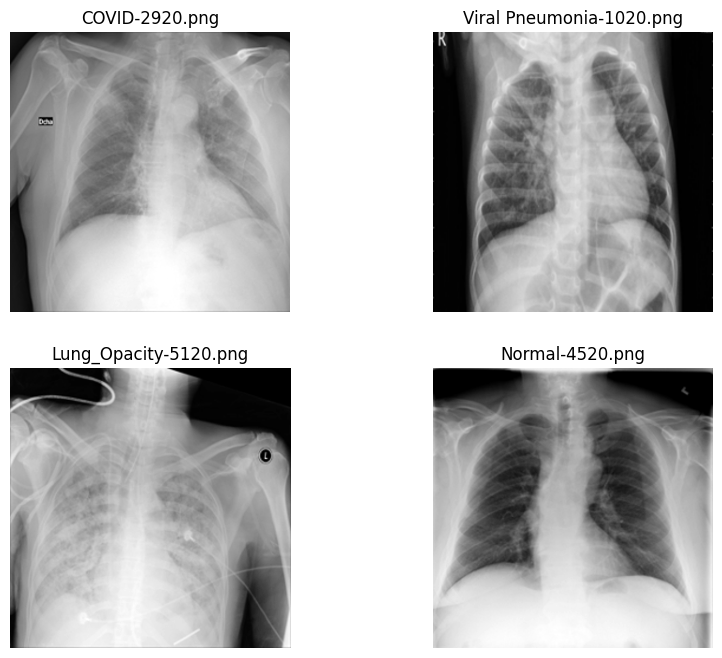

In [14]:
# create subplots
_, ax = plt.subplots(nrows=len(image_paths_map) // 2, ncols=2, figsize=(10, 8))
axes = ax.reshape(-1)

# get image at specified index
for i, (_, image_paths) in enumerate(image_paths_map.items()):
    for path in image_paths:
        if path.endswith(f"{image_index}.png"):
            break

    # plot each image in subplots
    plot_image(axes[i], path)

### Load data using `image_dataset_from_directory()`

The `image_dataset_from_directory()` function saves each image with a class label corresponding to the image's directory. This is a quick and easy way to get our data and its labels in the right format for embedding.

In [15]:
dataset = image_dataset_from_directory(
    "COVID-images",
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    seed=1,
    image_size=(299, 299),
    batch_size=1,
)

Found 6351 files belonging to 4 classes.


## 2. Create Image Vector Embeddings

To create our image embeddings, we will use a neural network that has been pre-trained on the brain tumor classification problem. In this example, we will use a network containing a ResNet-50 backbone. ResNet-50 is a popular neural network architecture for general image classification tasks.

ResNet-50 was originally trained on the ImageNet dataset - although this dataset contains millions of images, including of MRI scans, it does not contain examples of different brain tumor images. Therefore, our custom model was created by taking ResNet-50, pre-trained on ImageNet, and re-training it to classify MRI brain scan images.

This is an example of Transfer Learning - we are taking a model that has been pre-trained for a task (ResNet-50 for ImageNet classification) and using it as a starting point to solve a more specific problem (classify MRI brain scan images).s.

### Load Pre-Trained Classification Neural Network

In [16]:
model = tf.keras.models.load_model('saved_model/lungs_model.h5')

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 305, 305,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 150,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 150,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_3_c

 Total params: 27,784,066 (105.99 MB)

 Trainable params: 27,730,944 (105.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

We can see that the model has four layers: ResNet-50, Flatten, and two Dense layers. The ResNet-50 "layer" is really many layers, abstracted under one name. This is why it contains millions of parameters. The Flatten layer does not contain any parameters - its sole purpose is to "flatten" the outputs of ResNet-50 into a 2048-dimensional vector, known as a feature vector. The final two Dense layers transform the ResNet-50 feature vector into a 4-dimensional classification of the input image. 

### Transform Classification Network Into Embedding Network

For a better understanding of the `model.summary()`, here is a diagram representation of the network:

![mri-network-diagram](images/mri_network_diagram.png)

Although the Dense layers were essential for training ResNet-50 to classify our four brain tumor classes, we will no longer be needing them. In this example, we are interested in the embedding, not the classification output. Therefore, we will remove the last two layers of the pre-trained model by calling `pop()`. This means that the new output of the model is the 2048-dimensional feature vector - the ResNet-50 embedding of the input image.

In [18]:
model.pop()
model.pop()
model.summary()

AttributeError: 'Functional' object has no attribute 'pop'

### Use Embedding Network To Create Image Embeddings

##### Generate Embeddings

To generate the image embeddings, we will iterate through the dataset, get the 2048-dimension embedding by calling `model.predict()` on the image, and save the corresponding class vector.

In [18]:
# create empty arrays to store the embeddings and labels
embeddings = np.empty([len(dataset), 2048])
labels = np.empty([len(dataset), 4])

In [19]:
# for each image in dataset, get its embedding and class label
for i, image in tqdm(enumerate(dataset), total=len(dataset)):
    embeddings[i, :] = model.predict(image[0], verbose=0)
    labels[i, :] = image[1]

  0%|          | 0/6351 [00:00<?, ?it/s]

##### Define Class Labels

Now we have the class labels, we can get the tumor types by checking which index in the vector is equal to 1.

In [20]:
# list the tumor types in sorted order
tumor_types = sorted(image_paths_map.keys())

In [21]:
# for each vector, save the tumor type given by the high index
class_labels = [tumor_types[label.argmax()] for label in labels]

##### Define Image File Paths

It is often useful to save the entire filepath of the image, rather than just its name. In the cell below, we iterate through the files and save their filepaths.

In [22]:
# get a single list of all paths
all_paths = []
for _, image_paths in image_paths_map.items():
    all_paths += image_paths

In [23]:
# sort the source_files in alphanumeric order
sorted_all_paths = sorted(all_paths)

##### Define Embedding DataFrame

Now we have all of our components: the image filepath, the image class, and the vector embedding. The next step is to put it all in a DataFrame for insertion to KDBAI.

In [24]:
embedded_df = pd.DataFrame(
    {
        "source": sorted_all_paths,
        "class": class_labels,
        "embedding": embeddings.tolist(),
    }
)

In [25]:
show_df(embedded_df)

(6351, 3)


,source,class,embedding
0,COVID-images/COVID/COVID-1.png,COVID,"[0.1930886059999466, 0.7402693033218384, 0.066..."
1,COVID-images/COVID/COVID-1003.png,COVID,"[0.03127330541610718, 0.014013336971402168, 0...."
2,COVID-images/COVID/COVID-1006.png,COVID,"[0.4907979667186737, 0.06655334681272507, 0.44..."
3,COVID-images/COVID/COVID-1008.png,COVID,"[0.9774723649024963, 0.015101766213774681, 0.0..."
4,COVID-images/COVID/COVID-1013.png,COVID,"[0.32300350069999695, 0.11843094229698181, 0.5..."


### Visualising The Embeddings

It is often challenging to comprehend how feature embeddings are able to organize and cluster data because of their high dimensionality.
One trick is to use UMAP: a technique which reduces the number of dimensions to allow us to visualize the clustering in 2D.
This will give us a better idea of the success of the classification network, as well as some insight into where possible mis-classifications may occur.

##### Use UMAP To Reduce The Embeddings To Two Dimensions

In [26]:
_umap = umap.UMAP(n_neighbors=15, min_dist=0.0)

In [27]:
umap_df = pd.DataFrame(_umap.fit_transform(embeddings), columns=["u0", "u1"])

In [28]:
show_df(umap_df)

(6351, 2)


,u0,u1
0,15.363841,7.682234
1,-8.996799,11.274432
2,6.951149,10.431045
3,7.563979,15.374438
4,6.009036,8.207889


##### Visualise UMAP Dimensions

Now we will plot the Embeddings in 2D, with each class shown in a different color:

In [29]:
# define color for each class label
class_colors = ["blue", "red", "green", "purple"]

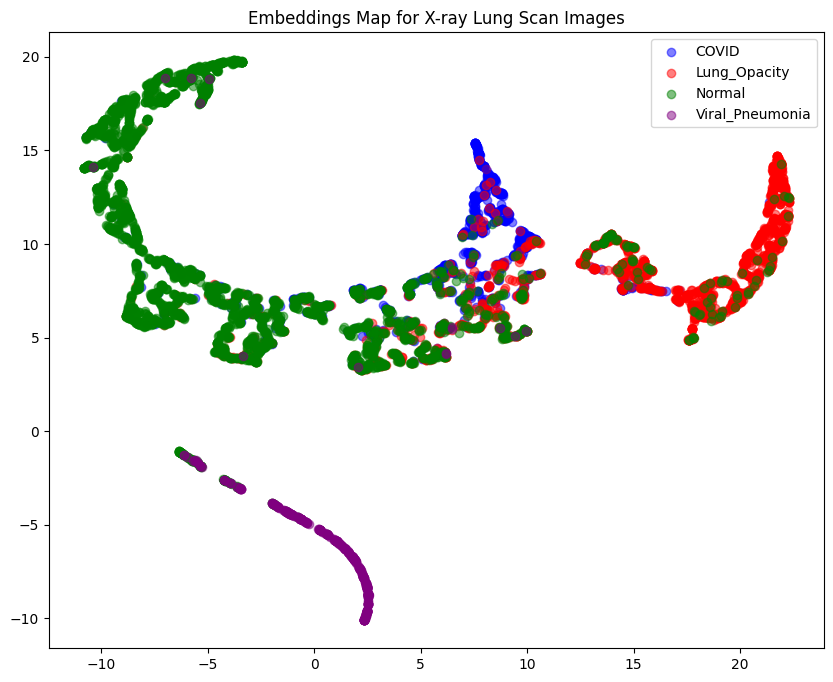

In [30]:
# Create a figure for plotting
plt.figure(figsize=(10, 8))

# Scatter plot with 'u0' and 'u1' columns as x and y, color mapped by class_labels
for tumor_type, color in zip(tumor_types, class_colors):
    indices_to_plot = [i for i, label in enumerate(class_labels) if label == tumor_type]
    subset = umap_df.iloc[indices_to_plot]
    plt.scatter(subset["u0"], subset["u1"], label=tumor_type, color=color, alpha=0.5)

# beutify plot
plt.title("Embeddings Map for X-ray Lung Scan Images")
plt.legend()
plt.show()

As shown above, the network is able to separate most of the data between classes, but there is still some overlap, especially with the glioma class (shown in blue). However, for the vast majority of points on the graph, their "nearest neighbors" belong to the same class as them. Therefore, when conducting vector similarity search using the embeddings, the majority of our results should be from the same class.

## 3. Store Embeddings in KDB.AI

##### Option 2. KDB.AI Server

To use KDB.AI Server, you will need download and run your own container.
To do this, you will first need to sign up for free [here](https://trykdb.kx.com/kdbaiserver/signup/). 

You will receive an email with the required license file and bearer token needed to download your instance.
Follow instructions in the signup email to get your session up and running.

Once the [setup steps](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html) are complete you can then connect to your KDB.AI Server session using `kdbai.Session` and passing your local endpoint.

In [31]:
session = kdbai.Session(endpoint="http://localhost:8082")

### Define Vector DB Table Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings. Our table will contain three columns, identical to those in our embeddings DataFrame: 
1. `source`: filepath to the raw image file
2. `class`: tumor class label
3. `embedding`: 2048-dimension feature vectors for similarity search

In [32]:
image_schema_l2_hnsw = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims": 2048, "metric": "L2", "type": "hnsw"},
        },
    ]
}
image_schema_ip_hnsw = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims": 2048, "metric": "IP", "type": "hnsw"},
        },
    ]
}
image_schema_cs_hnsw = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims": 2048, "metric": "CS", "type": "hnsw"},
        },
    ]
}
image_schema_l2_flat = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims": 2048, "metric": "L2", "type": "flat"},
        },
    ]
}
image_schema_ip_flat = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims": 2048, "metric": "IP", "type": "flat"},
        },
    ]
}
image_schema_cs_flat = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims": 2048, "metric": "CS", "type": "flat"},
        },
    ]
}


### Crate Vector DB Table

We then use the KDB.AI `create_table()` function to create a table that matches the defined schema in the vector database.

In [33]:
# ensure the table does not already exist
try:
    session.table("lungs_l2_hnsw").drop()
    #session.table("lungs_ip_hnsw").drop()
    #session.table("lungs_cs_hnsw").drop()
    #session.table("lungs_l2_flat").drop()
    #session.table("lungs_ip_flat").drop()
    #session.table("lungs_cs_flat").drop()
    #session.table("lungs_l2_ivfpq").drop()
    #session.table("lungs_ip_ivfpq").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [34]:
table_l2_hnsw = session.create_table("lungs_l2_hnsw", image_schema_l2_hnsw)
#table_ip_hnsw = session.create_table("lungs_ip_hnsw", image_schema_ip_hnsw)
#table_cs_hnsw = session.create_table("lungs_cs_hnsw", image_schema_cs_hnsw)
#table_l2_flat = session.create_table("lungs_l2_flat", image_schema_l2_flat)
#table_ip_flat = session.create_table("lungs_ip_flat", image_schema_ip_flat)
#table_cs_flat = session.create_table("lungs_cs_flat", image_schema_cs_flat)

In [35]:
try:
    session.table("newtable").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [36]:
table = session.create_table("newtable", image_schema_l2_hnsw)

### Add Embedded Data to KDB.AI Table

It is a good idea to check the memory usage of our data before inserting in to KDB.AI.

In [37]:
# convert bytes to MB
embedded_df.memory_usage(deep=True).sum() / (1024**2)

100.59794807434082

This dataset contains only 6MB, so we can insert all the data at once. For bigger image datasets, we should split the data into batches and insert <10MB at a time.

In [38]:
#Yield successive n-sized chunks from l.  
def divide_chunks(l, n):  
   # looping till length l  
    for i in range(0, len(l), n):   
        yield l[i:i + n]  
 
# How many elements each list should have  
n = len(embedded_df) // 12  

#You can then split up your dataset using the following line: 
embedded_df_split = list(divide_chunks(embedded_df, n)) 



In [42]:
#and then you can insert this into the table using: 
for i in tqdm(range(len(embedded_df_split))): 
    table_l2_hnsw.insert(embedded_df_split[i])   

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
for i in tqdm(range(len(embedded_df_split))): 
    table_ip_hnsw.insert(embedded_df_split[i]) 

In [ ]:
for i in tqdm(range(len(embedded_df_split))):
     table_cs_hnsw.insert(embedded_df_split[i]) 

In [ ]:
for i in tqdm(range(len(embedded_df_split))):
    table_l2_flat.insert(embedded_df_split[i])

In [ ]:
for i in tqdm(range(len(embedded_df_split))):
     table_ip_flat.insert(embedded_df_split[i])

In [ ]:
for i in tqdm(range(len(embedded_df_split))):
    table_cs_flat.insert(embedded_df_split[i]) 

In [39]:
#and then you can insert this into the table using: 
for i in tqdm(range(len(embedded_df_split))): 
    table.insert(embedded_df_split[i])   

  0%|          | 0/13 [00:00<?, ?it/s]

### Verify Data Has Been Inserted

Running `table.query()` should show us that data has been added.

In [43]:
session.list()

['lungs', 'lungs_l2_hnsw', 'newtable']

In [44]:
#table.query()
table_l2_hnsw.query()

,source,class,embedding
0,COVID-images/COVID/COVID-1.png,COVID,"[0.1930886059999466, 0.7402693033218384, 0.066..."
1,COVID-images/COVID/COVID-1003.png,COVID,"[0.03127330541610718, 0.014013336971402168, 0...."
2,COVID-images/COVID/COVID-1006.png,COVID,"[0.4907979667186737, 0.06655334681272507, 0.44..."
3,COVID-images/COVID/COVID-1008.png,COVID,"[0.9774723649024963, 0.015101766213774681, 0.0..."
4,COVID-images/COVID/COVID-1013.png,COVID,"[0.32300350069999695, 0.11843094229698181, 0.5..."
...,...,...,...
6346,COVID-images/Viral_Pneumonia/Viral Pneumonia-9...,Viral_Pneumonia,"[1.4559446753992233e-05, 1.8509032088331878e-0..."
6347,COVID-images/Viral_Pneumonia/Viral Pneumonia-9...,Viral_Pneumonia,"[4.3969259422738105e-05, 1.5448327758349478e-0..."
6348,COVID-images/Viral_Pneumonia/Viral Pneumonia-9...,Viral_Pneumonia,"[0.009182139299809933, 0.0017427902203053236, ..."
6349,COVID-images/Viral_Pneumonia/Viral Pneumonia-9...,Viral_Pneumonia,"[2.2270078261499293e-05, 0.0003343209391459822..."


## 4. Query KDB.AI Table

Now that all the embeddings of the images are in KDB.AI's database, it's time to demonstrate KDB.AI's fast query capabilities.

The `query` function accepts a wide range of arguments to make it easy to filter, aggregate, and sort.
Run `?table.query` to see them all.

Let's demonstrate this by filtering for images that contain "glioma" in the filename.

In [45]:
table_l2_hnsw.query(filter=[("like", "class", "*Lung*")])

,source,class,embedding
0,COVID-images/Lung_Opacity/Lung_Opacity-1.png,Lung_Opacity,"[0.11273650079965591, 0.42313218116760254, 0.4..."
1,COVID-images/Lung_Opacity/Lung_Opacity-10.png,Lung_Opacity,"[0.17577897012233734, 0.7366110682487488, 0.08..."
2,COVID-images/Lung_Opacity/Lung_Opacity-1009.png,Lung_Opacity,"[0.04618028178811073, 0.7661265730857849, 0.18..."
3,COVID-images/Lung_Opacity/Lung_Opacity-101.png,Lung_Opacity,"[0.053287386894226074, 0.9310305118560791, 0.0..."
4,COVID-images/Lung_Opacity/Lung_Opacity-1013.png,Lung_Opacity,"[0.10065077245235443, 0.7487967014312744, 0.15..."
...,...,...,...
1799,COVID-images/Lung_Opacity/Lung_Opacity-984.png,Lung_Opacity,"[0.004457301925867796, 0.9920989274978638, 0.0..."
1800,COVID-images/Lung_Opacity/Lung_Opacity-985.png,Lung_Opacity,"[0.0596608929336071, 0.6163009405136108, 0.324..."
1801,COVID-images/Lung_Opacity/Lung_Opacity-986.png,Lung_Opacity,"[0.06715655326843262, 0.8165585398674011, 0.11..."
1802,COVID-images/Lung_Opacity/Lung_Opacity-994.png,Lung_Opacity,"[0.00641989940777421, 0.9740433096885681, 0.01..."


## 5. Search For Similar Images To A Target Image

Finally, let's perform similarity search on the images. We do this using the `table.search()` function.

### Choose Example Image

First let's select a random row from our test dataset and plot the image.

In [55]:
# Get a sample row
random_row_index_1 = 240

In [56]:
# Select the random row and the desired column's value
random_row_1 = embedded_df.iloc[random_row_index_1]

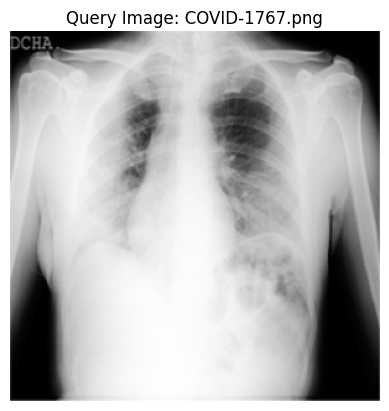

In [57]:
plot_image(plt.subplots()[-1], random_row_1["source"], label="Query Image")

We will save the embedding for this image in the `sample embedding` variable.

In [58]:
sample_embedding_1 = random_row_1["embedding"]

### Search Based On The Chosen Image

Using the the embeddings we extracted above in `sample_embedding` for this random image, we can call `table.search()` to find the `8` nearest neighbors to our query image.

In a real life scenario, the sample images used to search would be ones selected by a doctor.

In [59]:
#results_1 = table_l2_hnsw.search([sample_embedding_1], n=18)
results_1 = table_l2_hnsw.search([sample_embedding_1], n=9)
results_1[0]

,source,class,embedding,__nn_distance
0,COVID-images/COVID/COVID-1767.png,COVID,"[0.42490285634994507, 0.3861824572086334, 0.18...",0.000000
1,COVID-images/Lung_Opacity/Lung_Opacity-1803.png,Lung_Opacity,"[0.4211534261703491, 0.3949558138847351, 0.183...",0.000126
2,COVID-images/COVID/COVID-2089.png,COVID,"[0.4407655596733093, 0.37587782740592957, 0.18...",0.000390
3,COVID-images/COVID/COVID-655.png,COVID,"[0.43120771646499634, 0.36825278401374817, 0.2...",0.000493
4,COVID-images/COVID/COVID-3117.png,COVID,"[0.4168708920478821, 0.36917799711227417, 0.21...",0.000899
5,COVID-images/Normal/Normal-8613.png,Normal,"[0.41748014092445374, 0.3652346134185791, 0.21...",0.001184
6,COVID-images/COVID/COVID-1714.png,COVID,"[0.39237356185913086, 0.392313688993454, 0.213...",0.001713
7,COVID-images/Lung_Opacity/Lung_Opacity-2736.png,Lung_Opacity,"[0.4269469678401947, 0.41379106044769287, 0.15...",0.001774
8,COVID-images/COVID/COVID-109.png,COVID,"[0.42506760358810425, 0.3553791642189026, 0.21...",0.001874


In [60]:
results_2 = table.search([sample_embedding_1], n=9)
results_2[0]

,source,class,embedding,__nn_distance
0,COVID-images/COVID/COVID-1767.png,COVID,"[0.42490285634994507, 0.3861824572086334, 0.18...",0.000000
1,COVID-images/Lung_Opacity/Lung_Opacity-1803.png,Lung_Opacity,"[0.4211534261703491, 0.3949558138847351, 0.183...",0.000126
2,COVID-images/COVID/COVID-2089.png,COVID,"[0.4407655596733093, 0.37587782740592957, 0.18...",0.000390
3,COVID-images/COVID/COVID-655.png,COVID,"[0.43120771646499634, 0.36825278401374817, 0.2...",0.000493
4,COVID-images/COVID/COVID-3117.png,COVID,"[0.4168708920478821, 0.36917799711227417, 0.21...",0.000899
5,COVID-images/Normal/Normal-8613.png,Normal,"[0.41748014092445374, 0.3652346134185791, 0.21...",0.001184
6,COVID-images/COVID/COVID-1714.png,COVID,"[0.39237356185913086, 0.392313688993454, 0.213...",0.001713
7,COVID-images/Lung_Opacity/Lung_Opacity-2736.png,Lung_Opacity,"[0.4269469678401947, 0.41379106044769287, 0.15...",0.001774
8,COVID-images/COVID/COVID-109.png,COVID,"[0.42506760358810425, 0.3553791642189026, 0.21...",0.001874


In [61]:
tab = session.table("lungs")
res = tab.search([sample_embedding_1], n=9)
res[0]

,source,class,embedding,__nn_distance
0,COVID-images/COVID/COVID-389.png,COVID,"[0.9950439929962158, 0.0033893492072820663, 0....",0.424392
1,COVID-images/COVID/COVID-302.png,COVID,"[0.9872400164604187, 0.009812476113438606, 0.0...",0.423827
2,COVID-images/COVID/COVID-552.png,COVID,"[0.988183856010437, 0.0077135334722697735, 0.0...",0.423636
3,COVID-images/COVID/COVID-741.png,COVID,"[0.9690572023391724, 0.028436996042728424, 0.0...",0.423190
4,COVID-images/COVID/COVID-1405.png,COVID,"[0.9652830362319946, 0.03201880678534508, 0.00...",0.422988
5,COVID-images/COVID/COVID-387.png,COVID,"[0.9816957712173462, 0.011743752285838127, 0.0...",0.422897
6,COVID-images/COVID/COVID-1008.png,COVID,"[0.9774723649024963, 0.015101766213774681, 0.0...",0.422563
7,COVID-images/COVID/COVID-595.png,COVID,"[0.9734203815460205, 0.01869882270693779, 0.00...",0.422316
8,COVID-images/COVID/COVID-283.png,COVID,"[0.9874628186225891, 0.001264440594241023, 0.0...",0.422193


The results returned from `table.search()` show the closest matches along with value of nearest neighbor distances `__nn_distance`.
Since our query vector is taken from this dataset, the "nearest neighbour" will be the query image itself, with a `__nn_distance` of zero.
As a result, to get the 8 nearest neighbours, we had to select the 9 most similar vectors to our vector.

### Plot Most Similar Images

Let's visualize these images.
The function `plot_test_result_with_8NN()` will plot our query image alongside its 8 nearest neighbours.
Before calling this function, will exclude the point itself.

In [51]:
def plot_test_result_with_8NN(test_file: str, neighbors: pd.Series) -> None:
    # create figure
    _, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
    axes = ax.reshape(-1)

    # plot query image
    plot_image(axes[0], test_file, "Test")

    # plot nearest neighbors
    for i, (_, value) in enumerate(neighbors.items(),start = 1):
        plot_image(axes[i], value, f"{i}-NN")

In [52]:
nn1_filenames = results_1[0][1:]["source"]

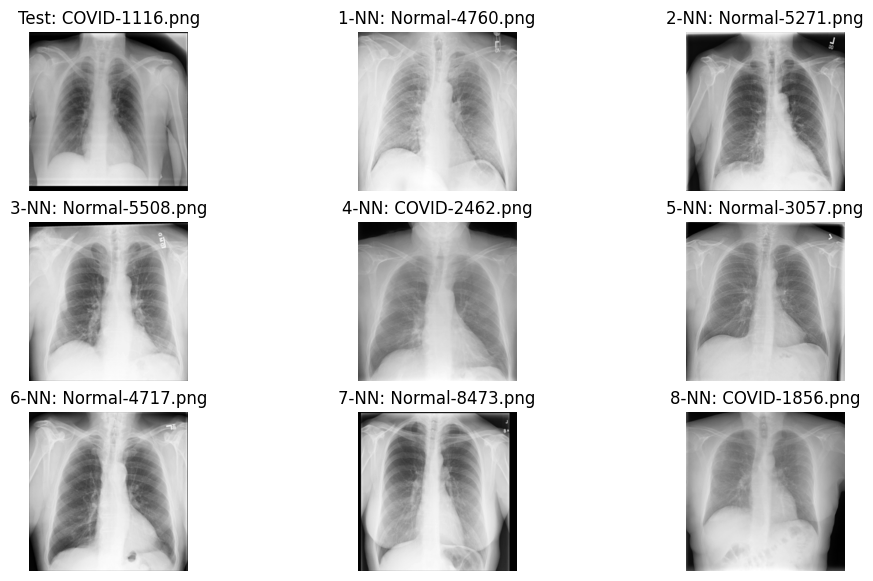

In [53]:
plot_test_result_with_8NN(random_row_1["source"], nn1_filenames)

We can see that the images returned are similar in nature to the test image.

### Automate This Search Process

In [55]:
def mri_image_nn_search(table, df: pd.DataFrame, row_index: int) -> None:
    # Select the random row and the desired column's value
    row = df.iloc[row_index]

    # get the embedding from this row
    row_embedding = row["embedding"]

    # search for 8 nearest neighbors (exclude self)
    nn_results = table.search([row_embedding], n=9)[0][1:]

    # plot the neighbors
    plot_test_result_with_8NN(row["source"], nn_results["source"])

Let's try another sample image and search for similar images.

In [56]:
# Get another row
random_row_index_2 = np.random.randint(0,len(embedded_df))
print(random_row_index_2)

3011


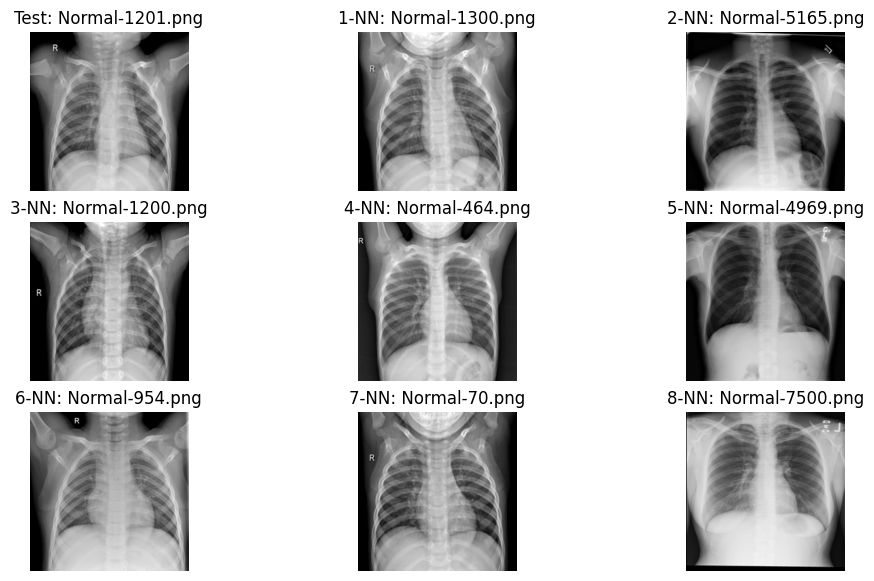

In [57]:
mri_image_nn_search(table, embedded_df, random_row_index_2)

We can see with this second test image that we get a set of similar brain scans back that match the second test image closely and are all in the same category. This kind of result can help a doctor confirm their own assumptions.

In [63]:
def accuracy_single (table, df:pd.DataFrame, num) -> None:
    row = df.iloc[num]
    embed = row["embedding"]
    neighbors = table.search([embed],n=9)[0][1:]
    accuracy = 0
    for i,category in enumerate(neighbors["class"]):
        if category == row["class"]:
            accuracy += 8 - i
    accuracy = accuracy / 36
    print(accuracy)

accuracy_single(table, embedded_df, random_row_index_2)

0.6388888888888888


In [141]:
 def accuracy_measure (table, df: pd.DataFrame) -> None: 
    full_accuracy = 0 
    for i in tqdm(range(6351)):
        row = df.iloc[i] 
        embed = row["embedding"] 
        neighbors = table.search([embed],n=18)[0][1::2] 
        accuracy = 0 
        for j,category in enumerate(neighbors["class"]): 
            if category == row["class"]: 
                accuracy += (8-j) 
        accuracy = accuracy/36 
        full_accuracy += accuracy 
    full_accuracy = full_accuracy/6351 
    print(full_accuracy) 

In [60]:
 def accuracy_measuret (table, df: pd.DataFrame) -> None: 
    full_accuracy = 0 
    for i in tqdm(range(6351)):
        row = df.iloc[i] 
        embed = row["embedding"] 
        neighbors = table.search([embed],n=9)[0][1:] 
        accuracy = 0 
        for j,category in enumerate(neighbors["class"]): 
            if category == row["class"]: 
                accuracy += (8-j) 
        accuracy = accuracy/36 
        full_accuracy += accuracy 
    full_accuracy = full_accuracy/6351 
    print(full_accuracy) 

In [143]:
accuracy_measure(table_l2_hnsw, embedded_df)

  0%|          | 0/6351 [00:00<?, ?it/s]

0.814534893892478


In [145]:
accuracy_measure(table_ip_hnsw, embedded_df)

  0%|          | 0/6351 [00:00<?, ?it/s]

0.7834461764551514


In [146]:
accuracy_measure(table_cs_hnsw, embedded_df)

  0%|          | 0/6351 [00:00<?, ?it/s]

0.8160525901432857


In [147]:
accuracy_measure(table_l2_flat, embedded_df)

  0%|          | 0/6351 [00:00<?, ?it/s]

0.8157464266344785


In [148]:
accuracy_measure(table_ip_flat, embedded_df)

  0%|          | 0/6351 [00:00<?, ?it/s]

0.8039941216606309


In [149]:
accuracy_measure(table_cs_flat, embedded_df)

  0%|          | 0/6351 [00:00<?, ?it/s]

0.8151690897321524


In [61]:
accuracy_measuret(table, embedded_df)

  0%|          | 0/6351 [00:00<?, ?it/s]

0.7625658251543943


In [71]:
embedded_df.iloc[1]

source                       COVID-images/COVID/COVID-1003.png
class                                                    COVID
embedding    [0.03127330541610718, 0.014013336971402168, 0....
Name: 1, dtype: object

In [84]:
table_l2_hnsw.search([embedded_df.iloc[596]["embedding"]],n=9)[0][1:]

,source,class,embedding,__nn_distance
1,COVID-images/COVID/COVID-2872.png,COVID,"[0.2533828914165497, 0.027774248272180557, 0.7...",0.000000
2,COVID-images/COVID/COVID-3293.png,COVID,"[0.24685877561569214, 0.027382439002394676, 0....",0.000067
3,COVID-images/COVID/COVID-3293.png,COVID,"[0.24685877561569214, 0.027382439002394676, 0....",0.000067
4,COVID-images/Lung_Opacity/Lung_Opacity-479.png,Lung_Opacity,"[0.2586807608604431, 0.020774029195308685, 0.7...",0.000080
5,COVID-images/Lung_Opacity/Lung_Opacity-479.png,Lung_Opacity,"[0.2586807608604431, 0.020774029195308685, 0.7...",0.000080
6,COVID-images/COVID/COVID-930.png,COVID,"[0.2598516643047333, 0.02837827242910862, 0.71...",0.000091
7,COVID-images/COVID/COVID-930.png,COVID,"[0.2598516643047333, 0.02837827242910862, 0.71...",0.000091
8,COVID-images/COVID/COVID-2033.png,COVID,"[0.2445647120475769, 0.03137919679284096, 0.72...",0.000117


In [108]:
newlist = table_l2_hnsw.search([embedded_df.iloc[596]["embedding"]],n=18)[0][0::2]
newlist["source"]

0                  COVID-images/COVID/COVID-2872.png
2                  COVID-images/COVID/COVID-3293.png
4     COVID-images/Lung_Opacity/Lung_Opacity-479.png
6                   COVID-images/COVID/COVID-930.png
8                  COVID-images/COVID/COVID-2033.png
10               COVID-images/Normal/Normal-3495.png
12    COVID-images/Lung_Opacity/Lung_Opacity-551.png
14                 COVID-images/COVID/COVID-1846.png
16               COVID-images/Normal/Normal-2954.png
Name: source, dtype: object

In [109]:
sourcelist={}
counter = 0
for i in newlist["source"]:
    sourcelist[counter] = i
    counter+=1

sourcelist

{0: 'COVID-images/COVID/COVID-2872.png',
 1: 'COVID-images/COVID/COVID-3293.png',
 2: 'COVID-images/Lung_Opacity/Lung_Opacity-479.png',
 3: 'COVID-images/COVID/COVID-930.png',
 4: 'COVID-images/COVID/COVID-2033.png',
 5: 'COVID-images/Normal/Normal-3495.png',
 6: 'COVID-images/Lung_Opacity/Lung_Opacity-551.png',
 7: 'COVID-images/COVID/COVID-1846.png',
 8: 'COVID-images/Normal/Normal-2954.png'}

In [110]:
sourcelist.items()

dict_items([(0, 'COVID-images/COVID/COVID-2872.png'), (1, 'COVID-images/COVID/COVID-3293.png'), (2, 'COVID-images/Lung_Opacity/Lung_Opacity-479.png'), (3, 'COVID-images/COVID/COVID-930.png'), (4, 'COVID-images/COVID/COVID-2033.png'), (5, 'COVID-images/Normal/Normal-3495.png'), (6, 'COVID-images/Lung_Opacity/Lung_Opacity-551.png'), (7, 'COVID-images/COVID/COVID-1846.png'), (8, 'COVID-images/Normal/Normal-2954.png')])

In [114]:
def accuracy_measure2 (table, df: pd.DataFrame) -> None: 
    full_accuracy = 0 
    for i in tqdm(range(6351)):
        row = df.iloc[i] 
        embed = row["embedding"] 
        neighbors = table.search([embed],n=18)[0][1::2] 
        accuracy = 0 
        for j,category in enumerate(neighbors["class"]): 
            if category == row["class"]: 
                accuracy += (8-j) 
        accuracy = accuracy/36 
        full_accuracy += accuracy 
    full_accuracy = full_accuracy/6351 
    print(full_accuracy) 

In [116]:
accuracy_measure2(table_l2_hnsw, embedded_df)

  0%|          | 0/6351 [00:00<?, ?it/s]

0.814534893892478


In [139]:
i = np.random.randint(0,len(embedded_df))
print(i)
testneb = table_l2_hnsw.search([embedded_df.iloc[i]["embedding"]],n=18)[0][1::2]
testneb

2624


,source,class,embedding,__nn_distance
1,COVID-images/Lung_Opacity/Lung_Opacity-5636.png,Lung_Opacity,"[0.06924623996019363, 0.5265635848045349, 0.40...",0.000000
3,COVID-images/Lung_Opacity/Lung_Opacity-4309.png,Lung_Opacity,"[0.07207852602005005, 0.5231961011886597, 0.40...",0.000020
5,COVID-images/Lung_Opacity/Lung_Opacity-1499.png,Lung_Opacity,"[0.06245526298880577, 0.5303072929382324, 0.40...",0.000070
7,COVID-images/Lung_Opacity/Lung_Opacity-3869.png,Lung_Opacity,"[0.06280891597270966, 0.519738495349884, 0.417...",0.000276
9,COVID-images/Normal/Normal-8351.png,Normal,"[0.06610505282878876, 0.54017573595047, 0.3937...",0.000295
11,COVID-images/Normal/Normal-2400.png,Normal,"[0.05975794792175293, 0.514286458492279, 0.425...",0.000730
13,COVID-images/Lung_Opacity/Lung_Opacity-2577.png,Lung_Opacity,"[0.0925808995962143, 0.5117837190628052, 0.395...",0.000832
15,COVID-images/Normal/Normal-9915.png,Normal,"[0.03312378749251366, 0.5503163933753967, 0.41...",0.002034
17,COVID-images/Lung_Opacity/Lung_Opacity-29.png,Lung_Opacity,"[0.10341516137123108, 0.48768550157546997, 0.4...",0.002706


In [140]:
accuracy = 0
for i,cat in enumerate(testneb["class"]):
    if cat == testneb["class"][1]:
        print(i)
        accuracy += (8-i)
accuracy = accuracy / 36
accuracy

0
1
2
3
6
8


0.7777777777777778

## 6. Delete the KDB.AI Table

Once finished with the table, it is best practice to drop it.

In [52]:
table.drop()

True

## Take Our Survey

We hope you found this sample helpful! Your feedback is important to us, and we would appreciate it if you could take a moment to fill out our brief survey. Your input helps us improve our content.

[**Take the Survey**](https://delighted.com/t/pmv533GL)